In [1]:
import _pickle as pickle
from functools import reduce

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
from tqdm import tqdm
from matplotlib import pyplot as plt

from april import Evaluator
from april.fs import get_model_files
from april.fs import PLOT_DIR
from april.enums import Class, Base, Mode, Heuristic, Strategy
from april.utils import microsoft_colors

sns.set_style('white')
%config InlineBackend.figure_format = 'retina'

In [2]:
out_dir = PLOT_DIR / 'isj-2019'
cm_file = out_dir / 'cm.pkl'

Select first run of BINetv1 on Paper dataset

In [3]:
models = sorted([m.name for m in get_model_files() if m.ad == 'binetv1' and m.id == 1 and m.model == 'paper'])
evaluator = Evaluator(models[0])

## Plot in paper (Fig. 12)

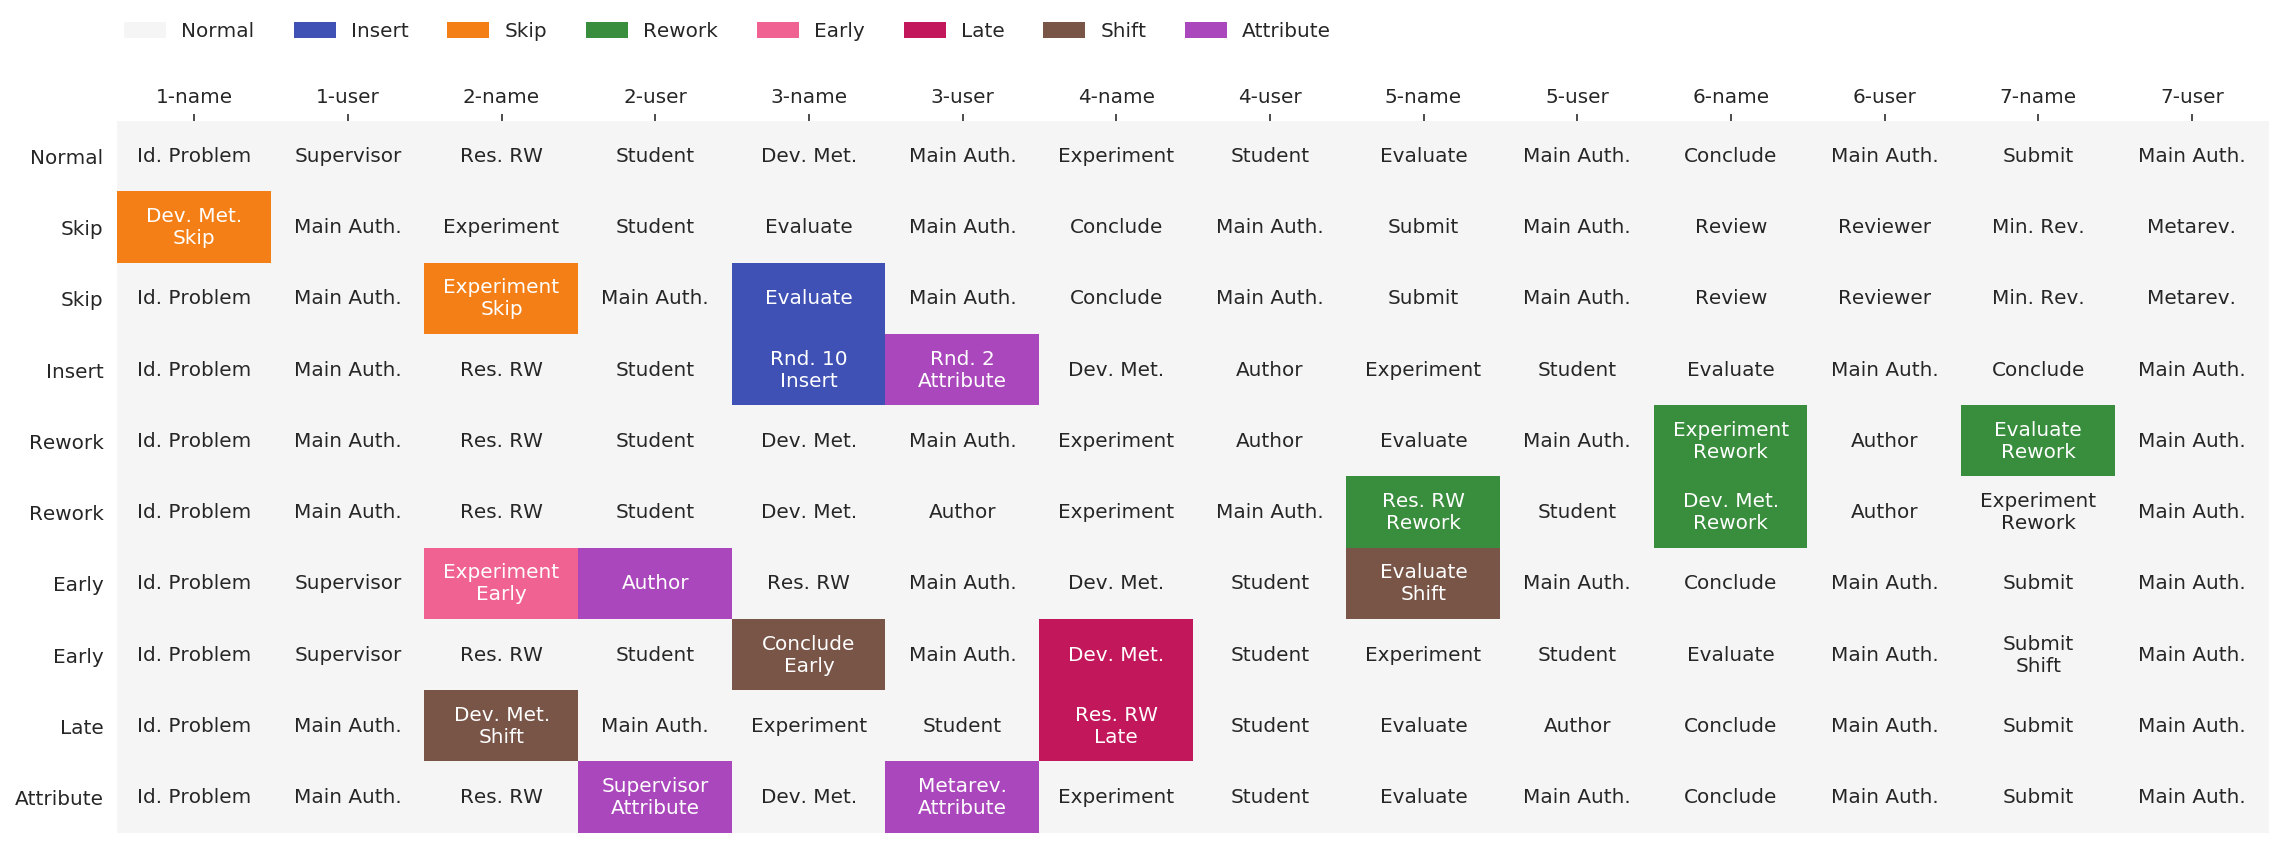

In [85]:
def prettify(df):
    df = df.replace('Research Related Work', 'Res. RW')
    df = df.replace('Identify Problem', 'Id. Problem')
    df = df.replace('Develop Method', 'Dev. Met.')
    df = df.replace('Develop Hypothesis', 'Dev. Hypot.')
    df = df.replace('Conduct Study', 'Cond. Study')
    df = df.replace('Minor Revision', 'Min. Rev.')
    df = df.replace('Final Decision', 'Final Dec.')
    df = df.replace('Random activity', 'Rnd.', regex=True)
    
    df = df.replace('Main Author', 'Main Auth.')
    df = df.replace('Metareviewer', 'Metarev.')
    df = df.replace('Random user', 'Rnd.', regex=True)
    
    return df

fig, ax = evaluator.plot_heatmap(mode=Mode.CLASSIFY, heuristic=Heuristic.LP_RIGHT, strategy=Strategy.ATTRIBUTE,
                                 min_event=1, max_event=8, short_labels=True, figsize=(16, 6),
                                 indices=[0, 475, 12, 18, 140, 1186, 334, 174, 557, 172], prettify_fn=prettify)
fig.tight_layout()

Add annotations to heatmap

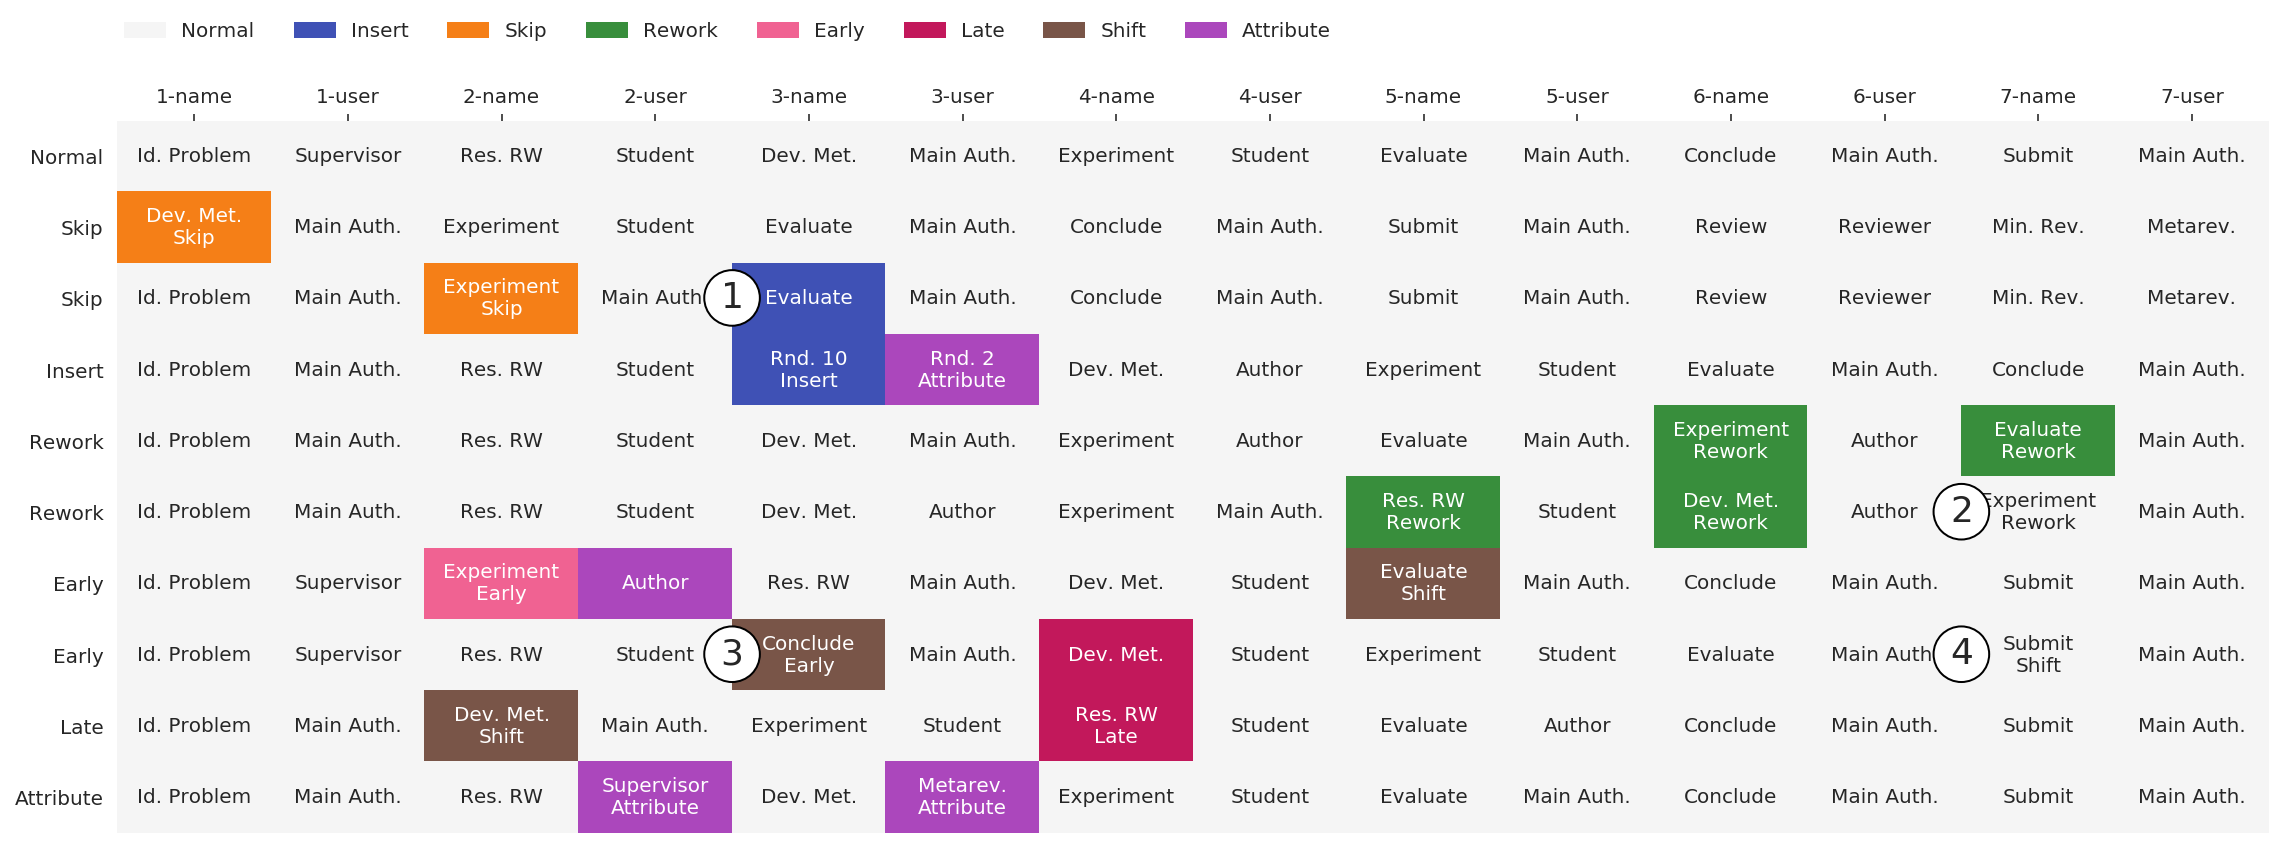

In [86]:
import matplotlib.patches as mpatch
import matplotlib.pyplot as plt

positions = [(4, 2), (12, 5), (4, 7), (12, 7)]

i = 1
for t in ax.texts:
    x, y = t.get_position()
    if (x-0.5, y-0.5) in positions:
        trans = t.get_transform()
        fig.text(x - 0.5, y + 0.13, i, ha="center", size=18, transform=trans, bbox=dict(boxstyle='Circle', fc="w", ec="k"))
        i += 1
fig.savefig(str(out_dir / 'classification.pdf'))
fig

## Evaluate Classification

In [5]:
def get_classification_df():
    models = sorted([m.name for m in get_model_files() if m.ad in ['binetv1'] and m.id >= 1 and 'bpic' not in m.model])
    
    cms = []
    for model in tqdm(models):
        e = Evaluator(model)
        
        y_true = e.binarizer.mask(e.dataset.classes)
        y_true[:, :, 1:][y_true[:, :, 1:] == Class.NORMAL] = Class.NORMAL_ATTRIBUTE

        _y_pred, tau = e.binarizer.binarize(base=Base.SCORES, strategy=Strategy.ATTRIBUTE, heuristic=Heuristic.LP_RIGHT, 
                                            go_backwards=False, return_parameters=True)
        y_pred = e.binarizer.classify(tau, e.dataset.features, _y_pred)
        
        labels = sorted(np.unique(y_true.compressed()))
        labels = labels[1:-1] + labels[:1] + labels[-1:]
        class_labels = np.array([Class.items().get(l).replace(' ', '\n') for l in labels])

        cm = sk.metrics.confusion_matrix(y_true.compressed(), y_pred.compressed(), labels=labels)
        cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
        cms.append(cm_df)
    
    with open(cm_file, 'wb') as f:
        pickle.dump(cms, f)
    
    return cms

if cm_file.exists():
    with open(cm_file, 'rb') as f:
        cms = pickle.load(f)
else:
    cms = get_classification_df()

## Plot featured in the paper (Fig. 13)

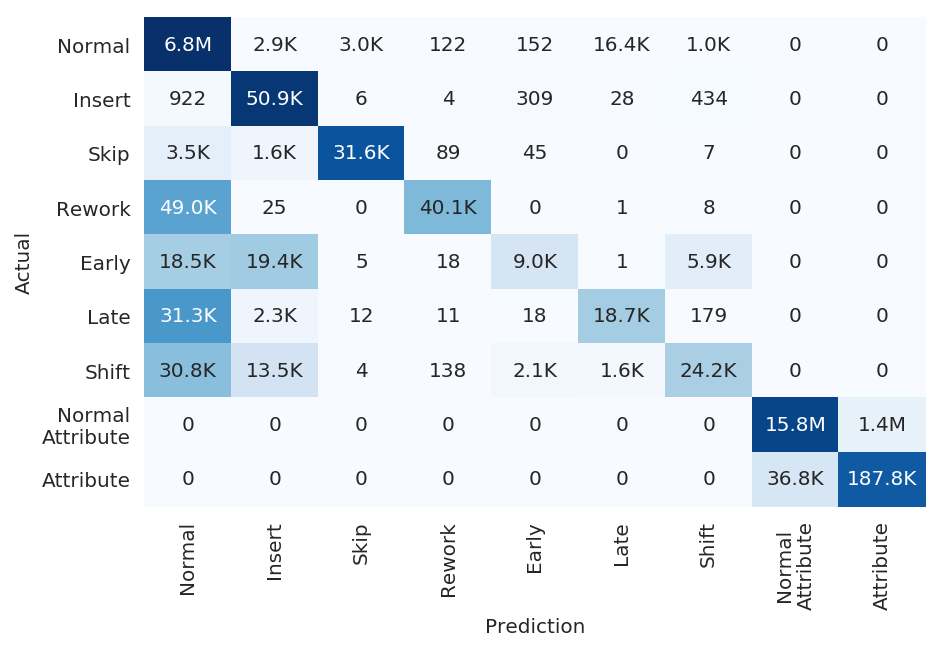

In [8]:
def prettify(n):
    if n > 1000000:
        return str(np.round(n / 1000000, 1)) + 'M'
    elif n > 1000:
        return str(np.round(n / 1000, 1)) + 'K'
    else:
        return str(n)

cm = reduce(lambda x, y: x.add(y, fill_value=0), cms)
annot = cm.applymap(prettify)
cm = (cm.T / cm.sum(axis=1)).T
    
fig, g = plt.subplots(figsize=(7, 4.5))
g = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False, rasterized=True, linewidths=0.)
_ = g.set(ylabel='Actual', xlabel='Prediction')
fig.tight_layout()
fig.savefig(str(out_dir / 'cm.pdf'))

## $F_1$ score values mentioned in the paper (Sec. 6)

Classification task

In [10]:
f1s = []
for cm in cms:
    cm = cm.values
    cm = np.vstack((cm[1:-2], cm[-1:]))  # Remove normal rows
    cm = np.hstack((cm[:, 1:-2], cm[:, -1:]))  # Remove normal columns
    r = np.diag(cm) / cm.sum(axis=1)
    p = np.diag(cm) / cm.sum(axis=0)
    f1s.append(2 * r.mean() * p.mean() / (r.mean() + p.mean()))
np.mean(f1s).round(4)

0.8346

End-to-end task

In [11]:
f1s = []
for cm in cms:
    cm = cm.values
    r = np.diag(cm) / cm.sum(axis=1)
    p = np.diag(cm) / cm.sum(axis=0)
    f1s.append(2 * r.mean() * p.mean() / (r.mean() + p.mean()))
np.mean(f1s).round(4)

0.6992

## In the following we demonstrate how to use the `plot_heatmap` function

### Anomaly Scores

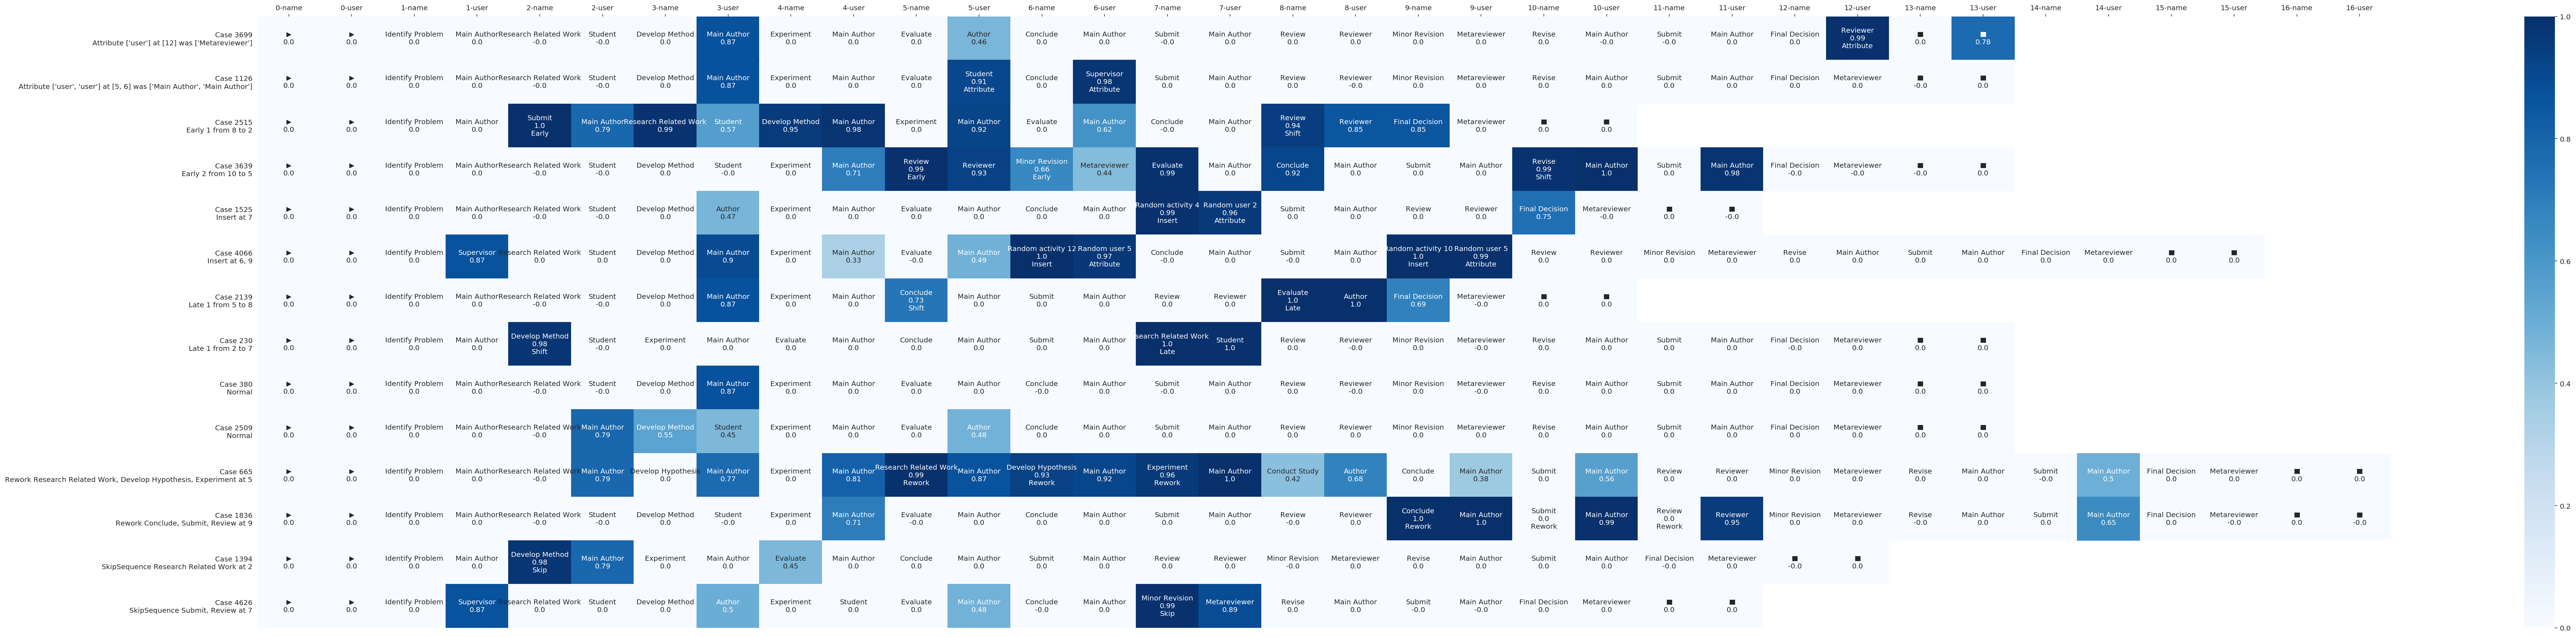

In [54]:
_ = evaluator.plot_heatmap(num_cases=20, anomaly_type='Anomaly', reduction='uniform', seed=0, mode=None)

### Binarized Anomaly Scores using $lp_\rightarrow^{(a)}$

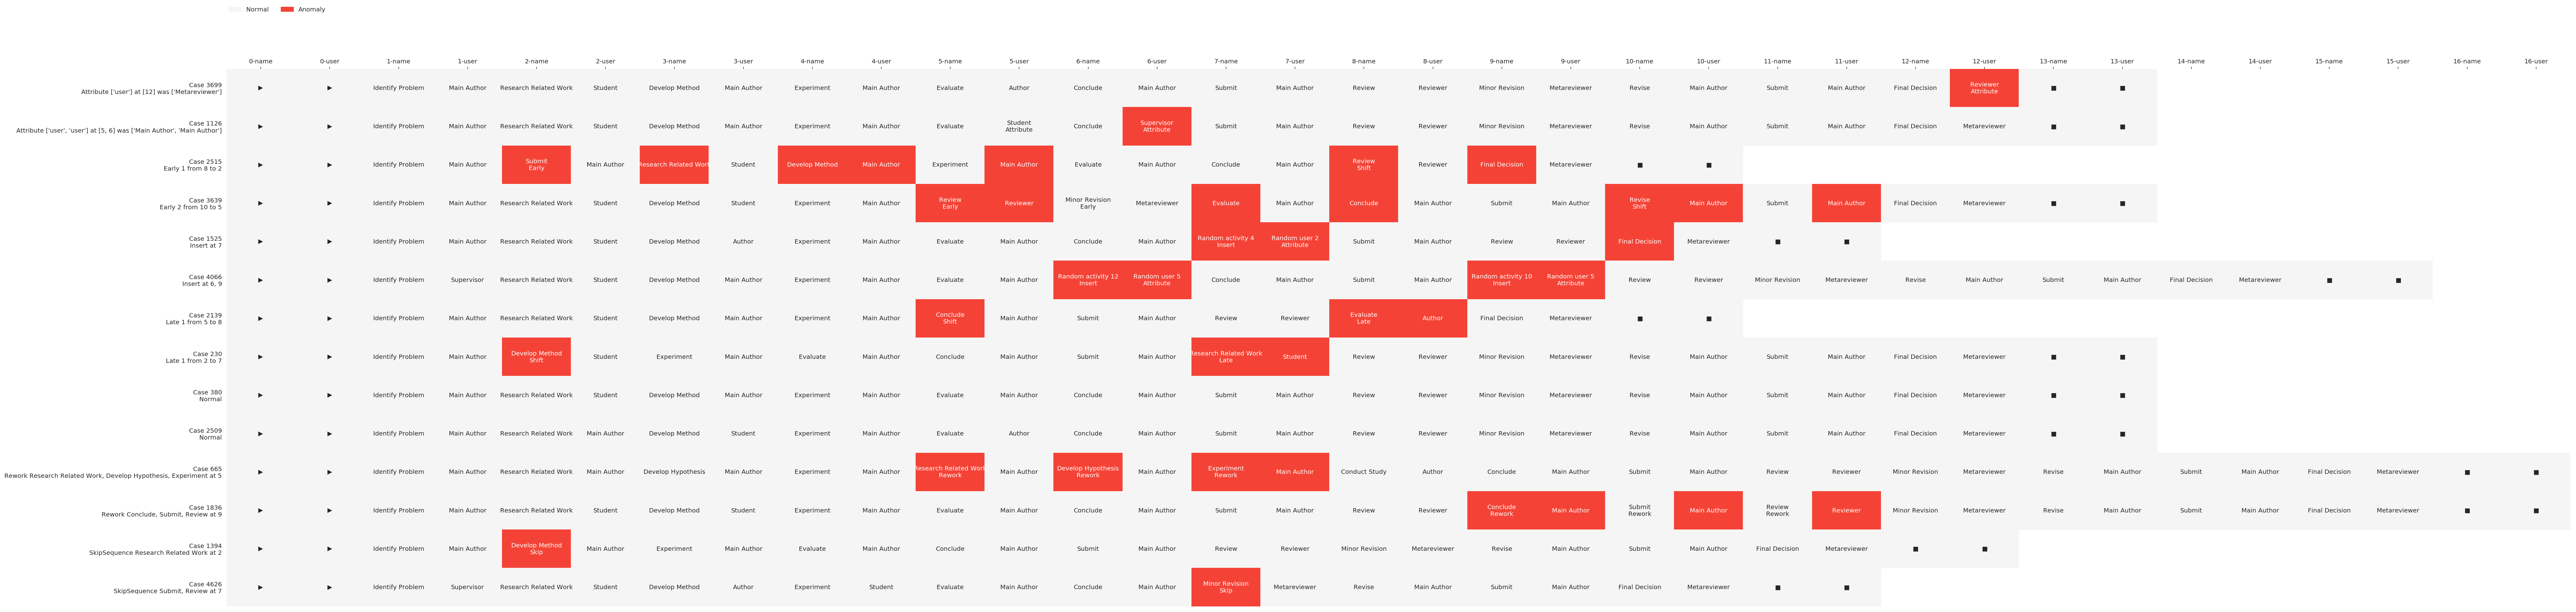

In [55]:
_ = evaluator.plot_heatmap(num_cases=20, anomaly_type='Anomaly', reduction='uniform', seed=0,
                           mode=Mode.BINARIZE, heuristic=Heuristic.LP_MEAN, strategy=Strategy.ATTRIBUTE)

### Classification using $lp_\rightarrow^{(a)}$

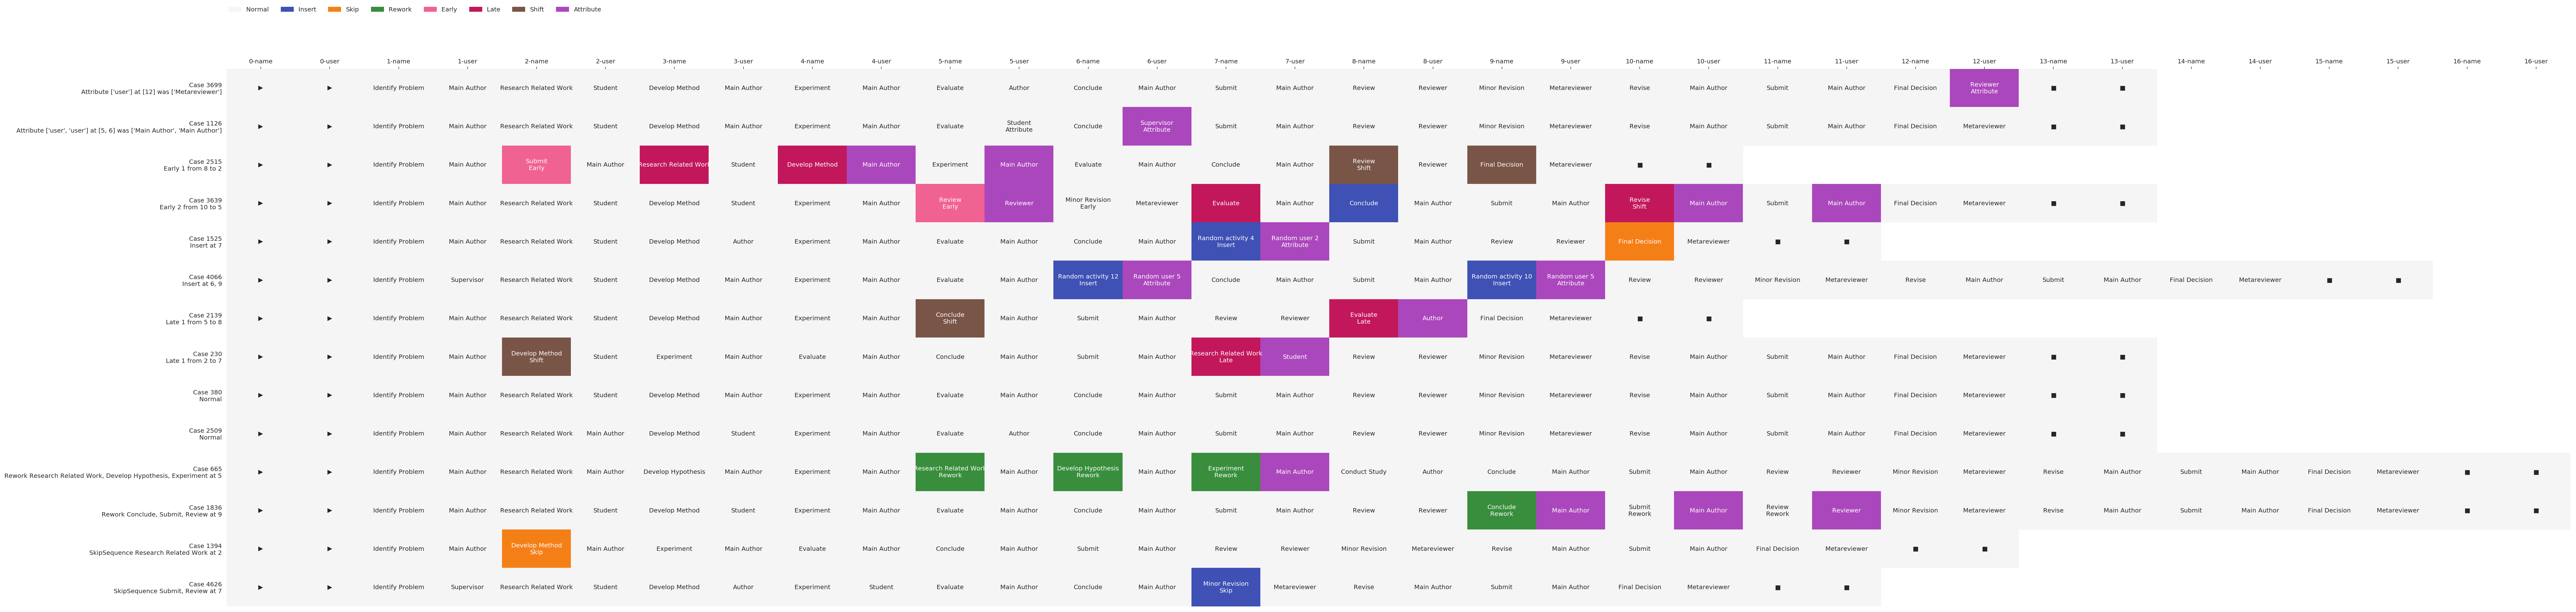

In [56]:
_ = evaluator.plot_heatmap(num_cases=20, anomaly_type='Anomaly', reduction='uniform', seed=0, 
                           mode=Mode.CLASSIFY, heuristic=Heuristic.LP_MEAN, strategy=Strategy.ATTRIBUTE)